In [468]:
# TODO: take away X,Y,Z from dataset and retrain model
# Work on getting confidence of each pick

In [469]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from PIL import Image
import tensorflow as tf
import math

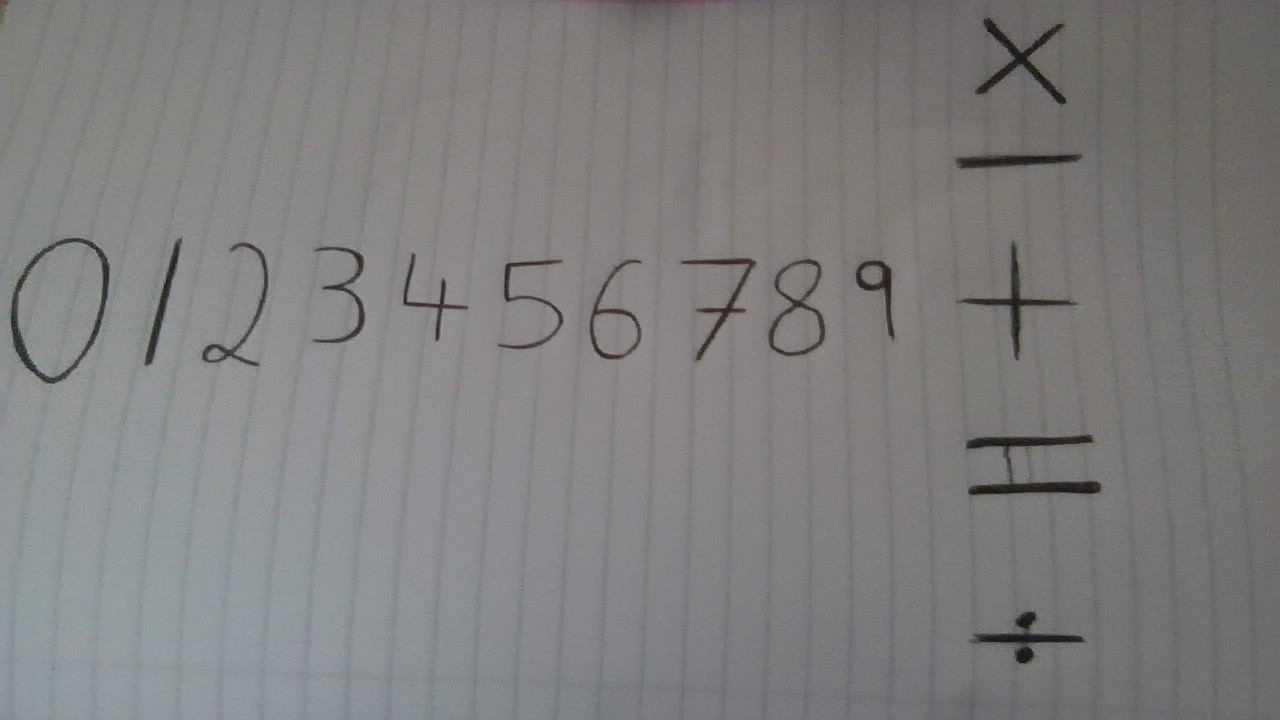

In [470]:
img = cv2.imread("INPUT_TEST_IMAGE_7.jpg")
cv2_imshow(img)

In [471]:
def adjustBrightness(image, brightness_factor):
    # scale pixel values by brightness factor
    return cv2.addWeighted(image, 1 + brightness_factor, image, 0, 0)

In [472]:
def adjustContrast(image, contrast_factor):
    # scale pixel values by contrast factor
    mean = cv2.mean(image)[0]
    return cv2.addWeighted(image, contrast_factor, image, 0, mean * (1 - contrast_factor))

In [473]:
def preprocessImage(img):
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  grayImg = cv2.GaussianBlur(grayImg, (5, 5), 0)
  brightnedImg = adjustBrightness(grayImg, 1.5)
  contrasted_gray = adjustContrast(brightnedImg, 2.0)

  # Method 1
  # filtered = cv2.bilateralFilter(contrasted_gray, 11, 17, 17)
  # thresh = cv2.adaptiveThreshold(contrasted_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
  # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  # cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  # Method 2
  ret, thresh = cv2.threshold(contrasted_gray, 200, 255, cv2.THRESH_BINARY)
  invertedThresh = cv2.bitwise_not(thresh)
  cv2_imshow(invertedThresh)

  return invertedThresh

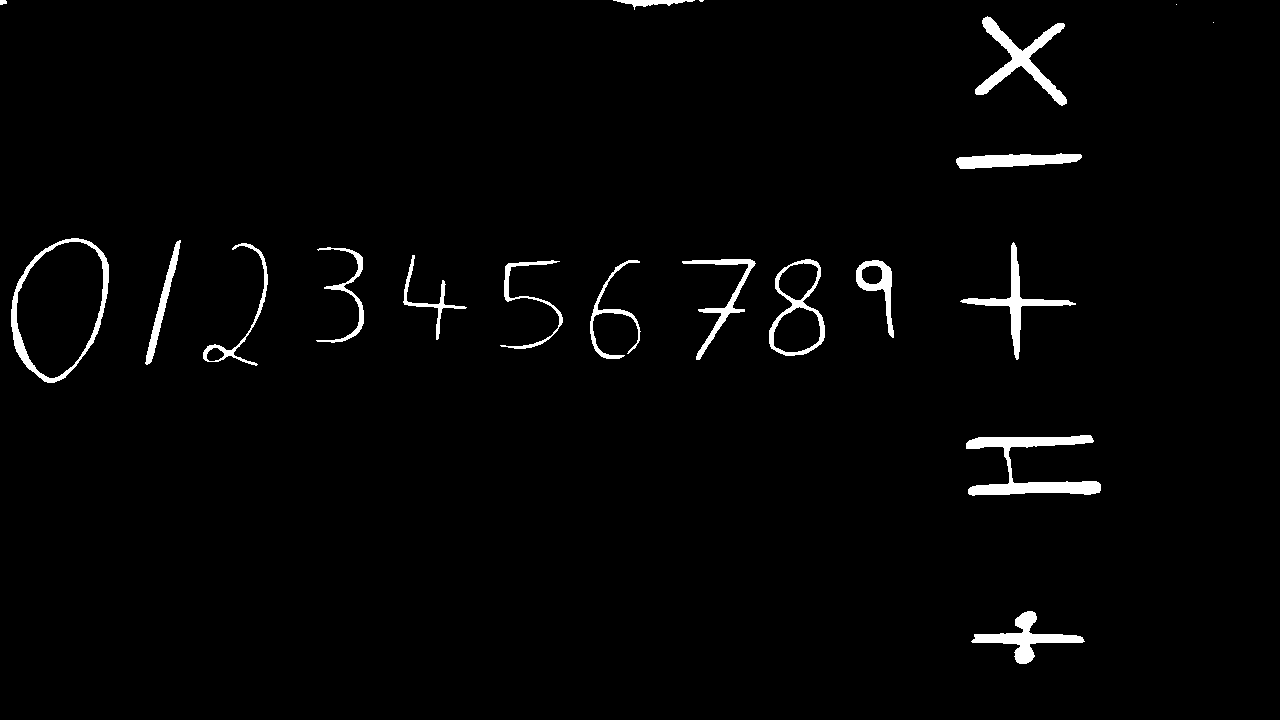

In [474]:
processedImg = preprocessImage(img)

In [475]:
def segmentImage(img):
  digits = []
  returnDigits = []
  contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for contour in contours:
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Crop the bounding rectangle from the original image
    digit = img[y:y+h, x:x+w]
    digits.append(digit)

    # removing images that are too small
    finalDigits = []
    for i in range(len(digits)):
        if np.shape(digits[i])[0] > 16:
          finalDigits.append(digits[i])

  for digit in finalDigits:
    h, w = digit.shape
    if w > h:
      startPoint = math.floor((w - h)/2)
      endPoint = startPoint + h
      newArray = np.zeros((w, w))
      newArray[startPoint:endPoint, :] = digit
      final = 255 - newArray
      returnDigits.append(final)
      cv2_imshow(newArray)
    elif h > w:
      startPoint = math.floor((h - w)/2)
      endPoint = startPoint + w
      newArray = np.zeros((h, h))
      newArray[:,startPoint:endPoint] = digit
      final = 255 - newArray
      returnDigits.append(final)
      cv2_imshow(newArray)


  return returnDigits

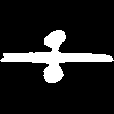

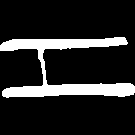

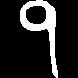

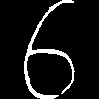

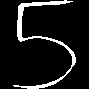

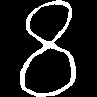

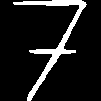

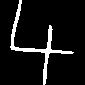

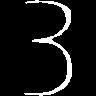

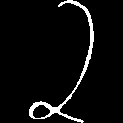

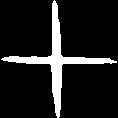

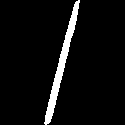

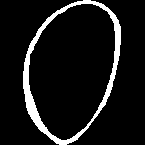

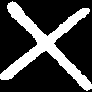

In [476]:
digits = segmentImage(processedImg)

In [477]:
model = tf.keras.models.load_model('DigitClassifier2.h5')

In [478]:
def predictValues(digits):
  predictions = []
  invertedArrays = {}
  for digitIndex in range(len(digits)):
    digit = digits[digitIndex]
    # invertedArray = 255 - digit
    # invertedArray = cv2.bitwise_not(digit)
    # cv2_imshow(invertedArray)


    image = Image.fromarray(digit)
    resized_image = image.resize((64, 64))
    numpy_image = asarray(resized_image)
    # cv2_imshow(numpy_image)
    finalArray = np.reshape(numpy_image, (1, 64, 64, 1))
    # invertedArrays[digitIndex] = finalArray


    prediction = model.predict(finalArray)
    predictions.append(prediction)
  return predictions

In [479]:
predictions = predictValues(digits)

1/1 [==============================] - 0s 26ms/step


In [480]:
def getIndexMappingPrediction(predicted_class_index):
  string_to_index = {
        "0": 0,
        "1": 1,
        "2": 2,
        "3": 3,
        "4": 4,
        "5": 5,
        "6": 6,
        "7": 7,
        "8": 8,
        "9": 9,
        "add": 10,
        "dec": 11,
        "eq": 12,
        "div": 13,
        "mul": 14,
        "sub": 15,
        "none": 16,
    }
  index_to_string = {v: k for k, v in string_to_index.items()}
  predicted_class_label = index_to_string[predicted_class_index]
  return predicted_class_label

In [481]:
labels = []
for prediction in predictions:
  predicted_class_index = np.argmax(prediction)
  label = getIndexMappingPrediction(predicted_class_index)
  labels.append(label)

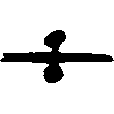

div


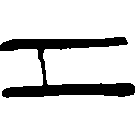

6


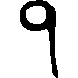

9


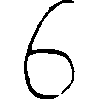

6


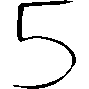

5


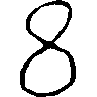

8


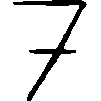

8


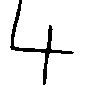

4


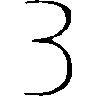

3


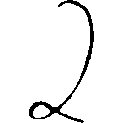

3


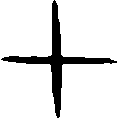

add


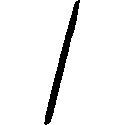

6


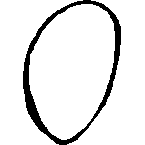

0


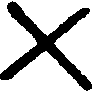

mul


In [482]:
for index in range(len(digits)):
  cv2_imshow(digits[index])
  print(labels[index])